<a href="https://colab.research.google.com/github/2023Shoggy/M.Sc-Thesis/blob/main/MSCTHESIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patool
!pip install pydot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract the .rar file
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar", outdir="datasets")

INFO patool: Extracting /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar ...
INFO:patool:Extracting /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar ...
INFO patool: ... creating output directory `datasets'.
INFO:patool:... creating output directory `datasets'.
INFO patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar"
INFO:patool:running /usr/bin/unrar x -- "/content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar"
INFO patool:     with cwd='datasets', input=''
INFO:patool:    with cwd='datasets', input=''
INFO patool: ... /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar extracted to `datasets'.
INFO:patool:... /content/drive/MyDrive/Dataset of Mammography with Benign Malignant Breast Masses.rar extracted to `datasets'.


'datasets'

## Project Title: Anomaly Detection in Mammography using CNN and Autoencoders

### Research Questions
Investigate the features of Convolutional Autoencoder (CAE) and Variational Autoencoder (VAE) vs DenseNets (CNN), How does different feature extraction techniques impact their performance in identifying anomalies in mammographic images?
Comparing the efficacy of Convolutional Autoencoder (CAE) and Variational Autoencoder (VAE) vs DenseNets (CNN), which of them is the most accurate in identifying anomalies in mammography images?

### Project Objectives
The primary objective of this project is to develop and evaluate advanced machine-learning models for detecting anomalies in mammography images. I will compare the performance of convolutional autoencoders (CAE) and variational autoencoders (VAE) against DenseNets (CNN) in identifying these anomalies to determine which model provides higher accuracy and reliability in anomaly detection. Another goal is to assess the computational efficiency and scalability of each model when applied to large datasets of mammography images. Additionally, the project intends to explore the interpretability of the model's outputs to ensure they can be effectively used in clinical settings. The project will provide insights into the strengths and weaknesses of each approach, and the findings from this report will contribute to improving the early detection of breast cancer through more accurate and efficient anomaly detection methods.

### Summary of project and background
This project focuses on the application of advanced machine learning techniques to detect anomalies in mammography images, which is crucial for early breast cancer detection. The research compares the efficacy of Convolutional Autoencoders (CAE) and Variational Autoencoders (VAE) with DenseNets (CNN) in identifying these anomalies. Mammography is a widely used screening tool for breast cancer, but the interpretation of images can be challenging and prone to human error. By leveraging deep learning models, the project aims to enhance the accuracy  and reliability of anomaly detection, potentially leading to better clinical outcomes. The background of this project lies in the need for more effective and automated methods to assist radiologists in diagnosing breast cancer. The use of CAE, VAE, and CNN models represents a cutting-edge approach in the field of medical image analysis. This research will contribute to the ongoing efforts to improve breast cancer screening and diagnosis through technological advancements.

In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve
)

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape,
    Lambda, BatchNormalization, Dropout, Activation, AveragePooling2D,
    GlobalAveragePooling2D, Concatenate
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K


# Refactor imports
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [ ]:
def count_files_in_directory(directory):
    try:
        # List all items in the directory
        items = os.listdir(directory)

        # Filter out directories, leaving only files
        files = [item for item in items if os.path.isfile(os.path.join(directory, item))]

        return len(files)
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0

# Example usage
directory_path = "datasets/Dataset of Mammography with Benign Malignant Breast Masses/MIAS Dataset/Benign Masses"
file_count = count_files_in_directory(directory_path)
print(f"Number of files in '{directory_path}': {file_count}")


Number of files in 'datasets/Dataset of Mammography with Benign Malignant Breast Masses/MIAS Dataset/Benign Masses': 2376


## Load Data

In [ ]:
data_dir = './datasets/Dataset of Mammography with Benign Malignant Breast Masses/MIAS Dataset'

# Load images using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training set
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(152, 152),
    batch_size=32,
    class_mode='input', # categorical will throw error
    subset='training'
)

# Validation set
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(152, 152),
    batch_size=32,
    class_mode='input',
    subset='validation'
)

Found 2672 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.


## Convolutional Autoencoder (CAE)


In [ ]:
class ConvolutionalAutoencoder:
    """
      Convolutional Autoencoder (CAE) class.
    """

    def __init__(self, input_shape=(150, 150, 3)):
        self.input_shape = input_shape
        self.layers = []  # Initialize the layers attribute
        self.model = self.build_model()

    def build_model(self, filters=[32, 64, 128], kernel_size=(3, 3), activation='relu', dropout_rate=0.3):
        input_img = Input(shape=self.input_shape)
        self.layers.append(input_img)

        # Encoder
        x = self.encoder(input_img, filters, kernel_size, activation, dropout_rate)

        # Decoder
        decoded = self.decoder(x, filters, kernel_size, activation, dropout_rate)

        # Compile the model
        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        return autoencoder

    def encoder(self, input_img, filters, kernel_size, activation, dropout_rate):
        x = input_img
        for f in filters:
            x = Conv2D(f, kernel_size, activation=activation, padding='same')(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D((2, 2), padding='same')(x)
            x = Dropout(dropout_rate)(x)
            self.layers.append(x)
        return x

    def decoder(self, encoded, filters, kernel_size, activation, dropout_rate):
        x = encoded
        for f in reversed(filters):
            x = Conv2D(f, kernel_size, activation=activation, padding='same')(x)
            x = BatchNormalization()(x)
            x = UpSampling2D((2, 2))(x)
            x = Dropout(dropout_rate)(x)
            self.layers.append(x)
        decoded = Conv2D(self.input_shape[2], kernel_size, activation='sigmoid', padding='same')(x)
        self.layers.append(decoded)
        return decoded

    def summary(self):
        return self.model.summary()

    def plot_model(self, filename='autoencoder_model.png'):

        return plot_model(self.model, to_file=filename, show_shapes=True, show_layer_names=True)

    def get_checkpoint_callback(self, checkpoint_path):
        return ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

    def get_tensorboard_callback(self, log_dir):
        return TensorBoard(log_dir=log_dir, histogram_freq=1)

    def get_early_stopping_callback(self):
        return EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    def get_reduce_lr_callback(self):
        return ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    def train(self, train_generator, validation_generator, epochs=40, checkpoint_path='training_checkpoints/cae/cp-{epoch:04d}.ckpt', log_dir='logs/cae'):
        # Get callbacks
        cp_callback = self.get_checkpoint_callback(checkpoint_path)
        tensorboard_callback = self.get_tensorboard_callback(log_dir)
        early_stopping = self.get_early_stopping_callback()
        reduce_lr = self.get_reduce_lr_callback()

        # Train the model
        return self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[cp_callback, tensorboard_callback, early_stopping, reduce_lr]
        )


    def evaluate(self, validation_generator, history):
        validation_generator.reset()
        predictions = self.model.predict(validation_generator)

        # Get true labels
        true_labels = validation_generator.classes

        # Reshape the predictions to match the true labels
        predicted_labels_reshaped = predictions.reshape(predictions.shape[0], -1).mean(axis=1)

        # Convert predictions to binary labels
        predicted_labels_binary = np.where(predicted_labels_reshaped > 0.5, 1, 0)

        # Calculate evaluation metrics
        accuracy = accuracy_score(true_labels, predicted_labels_binary)
        precision = precision_score(true_labels, predicted_labels_binary)
        recall = recall_score(true_labels, predicted_labels_binary)
        f1 = f1_score(true_labels, predicted_labels_binary)
        roc_auc = roc_auc_score(true_labels, predicted_labels_binary)

        # Print evaluation metrics
        print('Accuracy:', accuracy)
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1 Score:', f1)
        print('ROC-AUC:', roc_auc)

        # Set up 2x2 plot grid
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Draw a confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels_binary)
        cmd = ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant'])
        cmd.plot(cmap=plt.cm.Blues, ax=axs[0, 0])
        axs[0, 0].set_title('Confusion Matrix')

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(true_labels, predicted_labels_binary)
        roc_auc = auc(fpr, tpr)
        axs[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        axs[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[0, 1].set_xlim([0.0, 1.0])
        axs[0, 1].set_ylim([0.0, 1.05])
        axs[0, 1].set_xlabel('False Positive Rate')
        axs[0, 1].set_ylabel('True Positive Rate')
        axs[0, 1].set_title('Receiver Operating Characteristic')
        axs[0, 1].legend(loc="lower right")

        # Plot Precision-Recall curve
        precision, recall, _ = precision_recall_curve(true_labels, predicted_labels_binary)
        pr_auc = auc(recall, precision)
        axs[1, 0].plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
        axs[1, 0].set_xlabel('Recall')
        axs[1, 0].set_ylabel('Precision')
        axs[1, 0].set_title('Precision-Recall curve')
        axs[1, 0].legend(loc="lower left")

        # Plot training & validation loss values
        axs[1, 1].plot(history.history['loss'])
        axs[1, 1].plot(history.history['val_loss'])
        axs[1, 1].set_title('Model loss')
        axs[1, 1].set_ylabel('Loss')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].legend(['Train', 'Validation'], loc='upper left')

        # Adjust layout
        plt.tight_layout()
        plt.show()

        print('Evaluation completed.')

In [ ]:
# Instantiate the ConvolutionalAutoencoder class
cae = ConvolutionalAutoencoder()

# Display the model summary
cae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496 

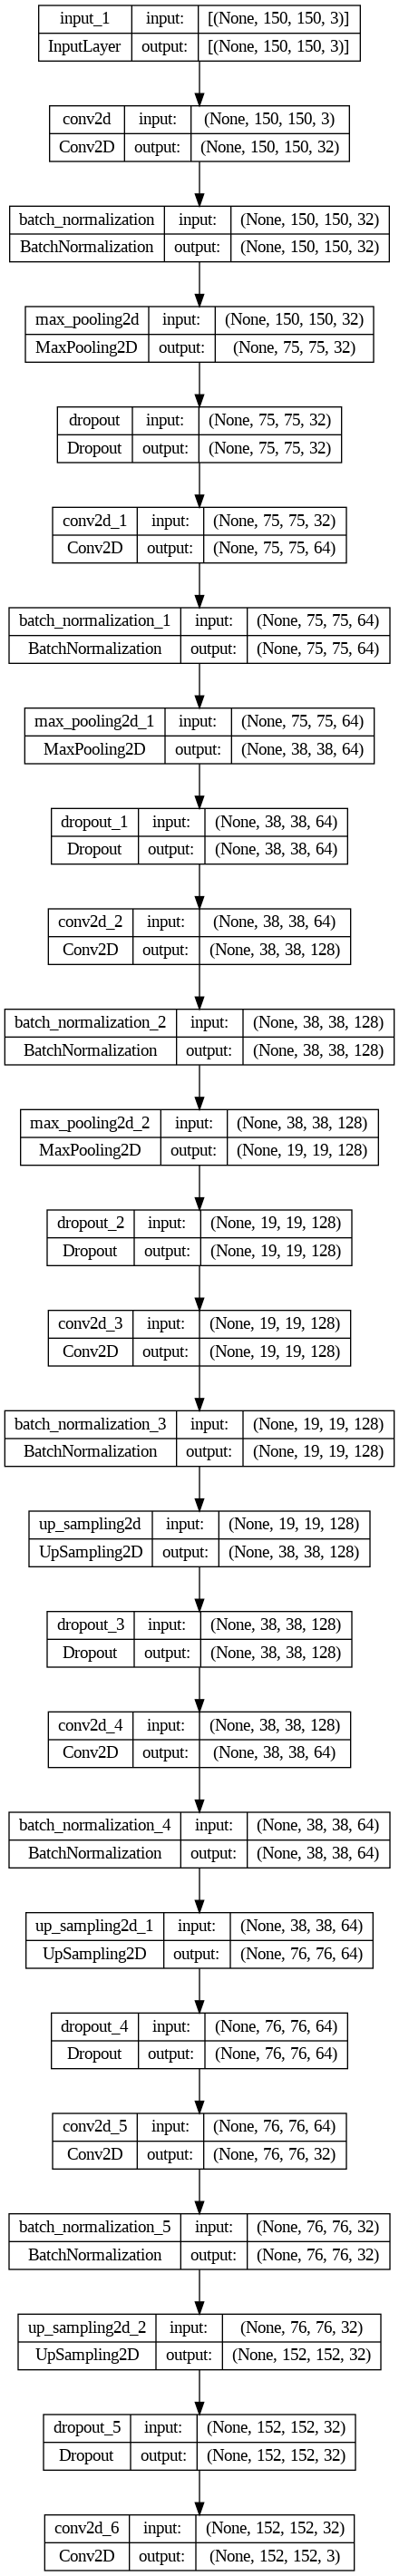

In [ ]:
# Generate and save the model diagram
cae.plot_model()

In [ ]:
# Train the model
cae_history = cae.train(train_generator, validation_generator)

Epoch 1/40
84/84 [==============================] - ETA: 0s - loss: 0.5415
Epoch 1: saving model to training_checkpoints/cae/cp-0001.ckpt
84/84 [==============================] - 36s 308ms/step - loss: 0.5415 - val_loss: 0.4834 - lr: 0.0010
Epoch 2/40
84/84 [==============================] - ETA: 0s - loss: 0.3664
Epoch 2: saving model to training_checkpoints/cae/cp-0002.ckpt
84/84 [==============================] - 24s 282ms/step - loss: 0.3664 - val_loss: 0.4758 - lr: 0.0010
Epoch 3/40
84/84 [==============================] - ETA: 0s - loss: 0.3500
Epoch 3: saving model to training_checkpoints/cae/cp-0003.ckpt
84/84 [==============================] - 24s 281ms/step - loss: 0.3500 - val_loss: 0.4597 - lr: 0.0010
Epoch 4/40
84/84 [==============================] - ETA: 0s - loss: 0.3427
Epoch 4: saving model to training_checkpoints/cae/cp-0004.ckpt
84/84 [==============================] - 23s 278ms/step - loss: 0.3427 - val_loss: 0.4366 - lr: 0.0010
Epoch 5/40
84/84 [==================

In [ ]:
%tensorboard --logdir logs/cae

In [ ]:
# Evaluate the model
cae.evaluate(validation_generator, cae_history)

## Variational Autoencoder (VAE)

In [ ]:
class VariationalAutoencoder:
    def __init__(self, input_shape=(150, 150, 3), latent_dim=32):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.model = self.build_model()

    def build_model(self):
        input_img = Input(shape=self.input_shape)

        # Encoder
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        x = Dense(32, activation='relu')(x)

        # VAE specific: mean and log variance
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)

        # Sampling function
        def sampling(args):
            z_mean, z_log_var = args
            epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        z = Lambda(sampling)([z_mean, z_log_var])

        # Decoder
        decoder_input = Input(shape=(self.latent_dim,))
        x = Dense(np.prod(shape_before_flattening), activation='relu')(decoder_input)
        x = Reshape(shape_before_flattening)(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        # Define encoder and decoder models
        encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
        decoder = Model(decoder_input, decoded, name='decoder')

        # Define VAE model
        output = decoder(encoder(input_img)[2])
        vae = Model(input_img, output, name='vae')

        # VAE loss
        reconstruction_loss = K.sum(K.binary_crossentropy(K.flatten(input_img), K.flatten(output)), axis=-1)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae.add_loss(vae_loss)

        vae.compile(optimizer='adam')
        return vae

    def summary(self):
        return self.model.summary()

    def plot_model(self, filename='vae_model.png'):
        plot_model(self.model, to_file=filename, show_shapes=True, show_layer_names=True)

    def train(self, train_generator, validation_generator, epochs=40, checkpoint_path='training_checkpoints/vae/cp-{epoch:04d}.ckpt'):
        checkpoint_dir = os.path.dirname(checkpoint_path)

        # Create a callback that saves the model's weights
        cp_callback = ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            period=1)

        # Create a TensorBoard callback
        tensorboard_callback = TensorBoard(log_dir='./logs/vae')

        # Train the model with the new callbacks
        history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[cp_callback, tensorboard_callback]
        )
        return history

    def evaluate(self, validation_generator, history):
        validation_generator.reset()
        predictions = self.model.predict(validation_generator)

        # Get true labels
        true_labels = validation_generator.classes

        # Reshape the predictions to match the true labels
        predicted_labels_reshaped = predictions.reshape(predictions.shape[0], -1).mean(axis=1)

        # Convert predictions to binary labels
        predicted_labels_binary = np.where(predicted_labels_reshaped > 0.5, 1, 0)

        # Calculate evaluation metrics
        accuracy = accuracy_score(true_labels, predicted_labels_binary)
        precision = precision_score(true_labels, predicted_labels_binary)
        recall = recall_score(true_labels, predicted_labels_binary)
        f1 = f1_score(true_labels, predicted_labels_binary)
        roc_auc = roc_auc_score(true_labels, predicted_labels_binary)

        # Print evaluation metrics
        print('Accuracy:', accuracy)
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1 Score:', f1)
        print('ROC-AUC:', roc_auc)

        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels_binary)
        cmd = ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant'])
        cmd.plot(cmap=plt.cm.Blues, ax=axs[0, 0])
        axs[0, 0].set_title('Confusion Matrix')

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(true_labels, predicted_labels_binary)
        roc_auc = auc(fpr, tpr)
        axs[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        axs[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[0, 1].set_xlim([0.0, 1.0])
        axs[0, 1].set_ylim([0.0, 1.05])
        axs[0, 1].set_xlabel('False Positive Rate')
        axs[0, 1].set_ylabel('True Positive Rate')
        axs[0, 1].set_title('Receiver Operating Characteristic')
        axs[0, 1].legend(loc="lower right")

        # Plot Precision-Recall curve
        precision, recall, _ = precision_recall_curve(true_labels, predicted_labels_binary)
        pr_auc = auc(recall, precision)
        axs[1, 0].plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
        axs[1, 0].set_xlabel('Recall')
        axs[1, 0].set_ylabel('Precision')
        axs[1, 0].set_title('Precision-Recall curve')
        axs[1, 0].legend(loc="lower left")

        # Plot model training and validation loss
        # history = self.model.history
        axs[1, 1].plot(history.history['loss'], label='Training Loss')
        axs[1, 1].plot(history.history['val_loss'], label='Validation Loss')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Loss')
        axs[1, 1].set_title('Training and Validation Loss')
        axs[1, 1].legend()

        print('Evaluation completed.')

        plt.tight_layout()
        return plt.show()

In [ ]:
# Instantiate the VariationalAutoencoder class
vae = VariationalAutoencoder()

# Display the model summary
vae.summary()

In [ ]:
# Generate and save the model diagram
vae.plot_model()

In [ ]:
# Train the model
vae_history = vae.train(train_generator, validation_generator)

In [ ]:
%tensorboard --logdir logs/vae

In [ ]:
# Evaluate the model
vae.evaluate(validation_generator, vae_history)

## DenseNets (CNN)

In [ ]:
# Load images using ImageDataGenerator
datagen_dense = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training set
train_generator_dense = datagen_dense.flow_from_directory(
    data_dir,
    target_size=(152, 152),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation set
validation_generator_dense = datagen_dense.flow_from_directory(
    data_dir,
    target_size=(152, 152),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

In [ ]:
# Define the DenseNet class
class DenseNet:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        inputs = layers.Input(shape=self.input_shape)
        x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        # Dense Block 1
        for _ in range(6):
            x = self.dense_block(x, 32)
        x = self.transition_layer(x)

        # Dense Block 2
        for _ in range(12):
            x = self.dense_block(x, 32)
        x = self.transition_layer(x)

        # Dense Block 3
        for _ in range(24):
            x = self.dense_block(x, 32)
        x = self.transition_layer(x)

        # Dense Block 4
        for _ in range(16):
            x = self.dense_block(x, 32)

        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = models.Model(inputs, outputs)
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def dense_block(self, x, growth_rate):
        for _ in range(2):
            y = layers.BatchNormalization()(x)
            y = layers.ReLU()(y)
            y = layers.Conv2D(4 * growth_rate, (1, 1), padding='same')(y)
            y = layers.BatchNormalization()(y)
            y = layers.ReLU()(y)
            y = layers.Conv2D(growth_rate, (3, 3), padding='same')(y)
            x = layers.Concatenate()([x, y])
        return x

    def transition_layer(self, x):
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(x.shape[-1] // 2, (1, 1), padding='same')(x)
        x = layers.AveragePooling2D((2, 2), strides=(2, 2), padding='same')(x)
        return x

    def get_tensorboard_callback(self, log_dir):
        return TensorBoard(log_dir=log_dir, histogram_freq=1)

    def get_early_stopping_callback(self):
        return EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    def get_reduce_lr_callback(self):
        return ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    def get_checkpoint_callback(self, checkpoint_path):
        return ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_format='tf')

    def train(self, train_generator, validation_generator, epochs=40, checkpoint_path='training_checkpoints/densenet/cp-{epoch:04d}.ckpt', log_dir='logs/densenet'):
        cp_callback = self.get_checkpoint_callback(checkpoint_path)
        tensorboard_callback = self.get_tensorboard_callback(log_dir)
        early_stopping = self.get_early_stopping_callback()
        reduce_lr = self.get_reduce_lr_callback()

        return self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[cp_callback, tensorboard_callback, early_stopping, reduce_lr]
        )

    def evaluate(self, test_data, history):
        # Evaluate the model
        evaluation = self.model.evaluate(test_data)
        print('Test loss:', evaluation[0])
        print('Test accuracy:', evaluation[1])

        # Predict the probabilities for the test data
        y_pred_prob = self.model.predict(test_data)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = test_data.classes

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 12))
        plt.subplot(2, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        # Precision-Recall Curve
        precision = dict()
        recall = dict()
        for i in range(self.num_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
        plt.subplot(2, 2, 2)
        for i in range(self.num_classes):
            plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')
        plt.legend(loc='best')

        # ROC Curve
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(self.num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.subplot(2, 2, 3)
        for i in range(self.num_classes):
            plt.plot(fpr[i], tpr[i], lw=2, label='class {} (area = {:.2f})'.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve')
        plt.legend(loc='best')

        # Training and Validation Loss
        plt.subplot(2, 2, 4)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend(loc='best')

        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()

    def summary(self):
        return self.model.summary()

    def plot_model(self, filename='densenet_model.png'):
        plot_model(self.model, to_file=filename, show_shapes=True, show_layer_names=True)

In [ ]:
# Initialize and train the DenseNet model
num_classes = len(train_generator_dense.class_indices)
densenet = DenseNet((152, 152, 3), num_classes)

In [ ]:
densenet.summary()

In [ ]:
densenet.plot_model()

In [ ]:
# Train the model
densenet_history = densenet.train(train_generator_dense, validation_generator_dense)

In [ ]:
# Evaluate the model
densenet.evaluate(validation_generator_dense, densenet_history)

In [ ]:
%tensorboard --logdir logs/densenet